# PyTorch Computer Vision

## 0. Computer vision libraries

* `torchvision` - base domain library for PyTorch computer vision
  * `torchvision.datasets` - datasets & data loading functions
  * `torchvision.models` - pretrained computer vision models
  * `torchvision.transforms` - functions for manipulating data
* `torch.utils.data.Dataset` - base dataset for PyTorch
* `torch.utils.data.DataLoader` - creates a Python iterable over a dataset

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


## 1. Getting a dataset

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True, # do we want the training dataset?
    download=True, # do we want to download?
    transform=ToTensor(), # transform to tensor
    target_transform=None # how do we want to transform the labels (targets)
)

test_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=False, # do we want the training dataset?
    download=True, # do we want to download?
    transform=ToTensor(), # transform to tensor
    target_transform=None # how do we want to transform the labels (targets)
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15683872.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269228.17it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4996065.97it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5592405.33it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
image, label = train_data[0]

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
#[coors, height, width]
# since it is grayscale, only one color channel
image.shape, label

(torch.Size([1, 28, 28]), 9)

### 1.2 Visualizing data

Text(0.5, 1.0, 'Ankle boot')

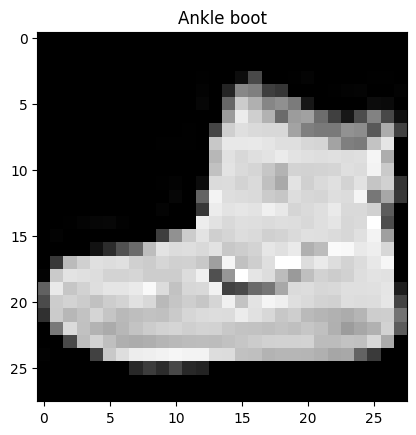

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

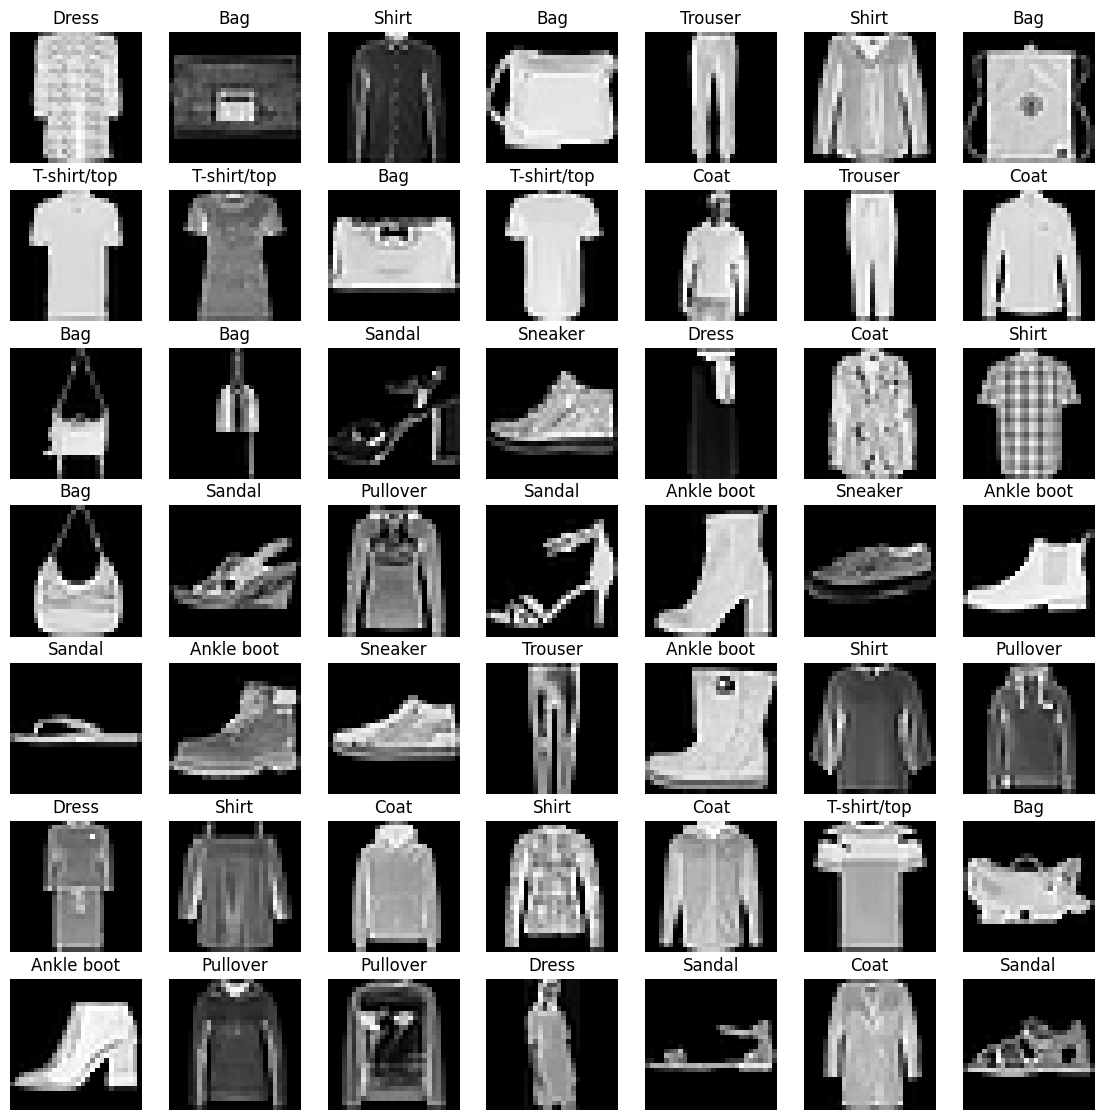

In [ ]:
# plot more images
torch.manual_seed(14)
fig = plt.figure(figsize=(14,14))
rows, cols = 7, 7
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 2. Prepare DataLoader

Right now, data is in the form of PyTorch Datasets.

DataLoader turns out dataset into a Python iterable

We want to split our data into bathces of 32.
1. This is more computationally efficient to train on rather than training on all 60,000 at once.
2. It also gives our neural network more chances to update its gradient per epoch.

In [ ]:
# Data is in the form of a PyTorch Dataset
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
from torch.utils.data import DataLoader

# batch size hyperparameter
BATCH_SIZE = 32

# Turn datsets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7857bc01a8f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7857bc01b580>)

In [ ]:
# Check out what we've craeted
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}.")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}.")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7857bc01a8f0>, <torch.utils.data.dataloader.DataLoader object at 0x7857bc01b580>)
Length of train_dataloader: 1875 batches of 32.
Length of test_dataloader: 313 batches of 32.


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


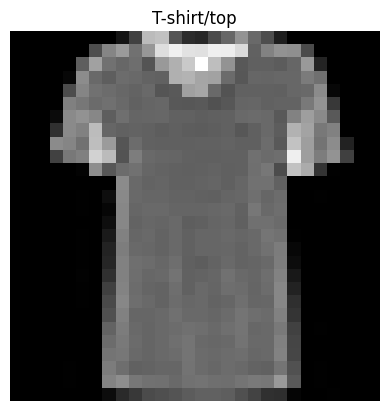

In [ ]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Build a baseline model

When starting to build a series of ML modelling experiments, it's best to start with a baseline model. Start simply and add complexity when necessary.

In [ ]:
# Creating a flatten layer
flatten_model = nn.Flatten()

# Get a simple sample
x = train_features_batch[0]
print(f"Pre-Flattenning Shape: {x.shape} -> [color channel, height, width]")

# Flatten
output = flatten_model(x) # perform forward pass
print(f"Post-Flattening Shape: {output.shape} -> [color channel, pixel~height*width]")

Pre-Flattenning Shape: torch.Size([1, 28, 28]) -> [color channel, height, width]
Post-Flattening Shape: torch.Size([1, 784]) -> [color channel, pixel~height*width]


In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int = 10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(14)

# Set up model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=10
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x).argmax().item()

6

### 3.1 Set up loss, optimizer, and evaluation metrics

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch Repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  # ↓ "Raw URL" from GitHub
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
    print("Success!")

Success!


In [ ]:
# import accuracy metric
from helper_functions import accuracy_fn
print(accuracy_fn)

<function accuracy_fn at 0x7857bc069e10>


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

In [ ]:
from timeit import default_timer as timer

In [ ]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds.")
  return total_time

In [ ]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds.


2.759400001650647e-05

### 3.3 Creating a training loop on batches and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Print statements
5. Time it all (for fun) :3



In [ ]:
# Import tqdm for progess bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(14)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### TRAINING ###

  # Reset loss every epoch
  train_loss = 0

  # Loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):

    model_0.train()

    # Forward pass
    y_pred = model_0(X)

    # Calculate the loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### TEST ###
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate test acc avg per batch
    test_acc /= len(test_dataloader)

  ### PRINT ###
  print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Calculate Training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device)
                                            )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.5846 | Test Loss: 0.6082, Test Acc: 77.6657
Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4737 | Test Loss: 0.4884, Test Acc: 83.0471
Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4545 | Test Loss: 0.4678, Test Acc: 83.6761
Train time on cpu: 42.149 seconds.


## 4. Make predictions and get results for `model_0`

In [ ]:
torch.manual_seed(14)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of the mdoel predicting on data_loader."""
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate loss & accuracy per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46784767508506775,
 'model_acc': 83.67611821086263}

## 5. Setup device-agnostic code (for using a GPU is there is one)

In [ ]:
!nvidia-smi

Thu Jan 18 19:43:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int = 10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(14)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### 6.1 Setup loss, optimizer, and evaluation metrics

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and testing loops

In [ ]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training step with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0
  model.train()


  # Loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss and accuracy per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  # Print
  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}")

In [ ]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  """Performs a testing step with model going over data_loader"""

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

In [ ]:
torch.manual_seed(14)

# Measure Time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

# Training & Testing Loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n---------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
---------
Train Loss: 1.23212 | Train Acc: 58.06
Test Loss: 1.03476 | Test Acc: 64.82
Epoch 1
---------
Train Loss: 0.58372 | Train Acc: 79.63
Test Loss: 0.50696 | Test Acc: 82.30
Epoch 2
---------
Train Loss: 0.47085 | Train Acc: 83.26
Test Loss: 0.47042 | Test Acc: 83.33
Train time on cuda: -2114.450 seconds.


In [ ]:
# Get model_1 results dictionary

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4704159200191498,
 'model_acc': 83.32667731629392}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46784767508506775,
 'model_acc': 83.67611821086263}

## 7. Model 2: CNN

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # you have to find this value manually
                  out_features=10)
    )

  def forward(self, x):
    #print(x.shape)

    x = self.conv_block_1(x)
    #print(x.shape)

    x = self.conv_block_2(x)
    #print(x.shape)

    x = self.classifier(x)
    #print(x.shape)

    return x

In [ ]:
torch.manual_seed(14)
print(len(class_names))
model_2 = FashionMNISTModelV2(input_shape=1, # number of color channels
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

10


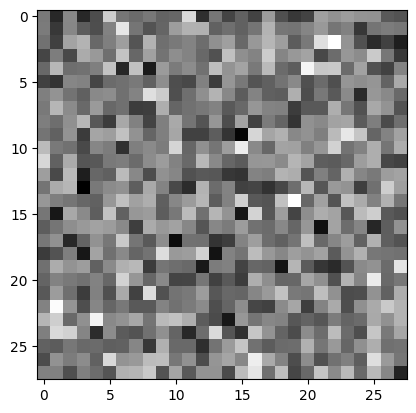

In [ ]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
plt.imshow(rand_image_tensor.squeeze(),cmap="gray")

In [ ]:
model_2(rand_image_tensor.unsqueeze(dim=0).to(device))

tensor([[ 0.1079, -0.0442, -0.0676, -0.0651, -0.1084,  0.0719,  0.0520, -0.1144,
         -0.0310,  0.0487]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
# torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [ ]:
test_image

tensor([[[-0.2087, -0.3219, -0.2481,  ...,  0.0691, -1.9226,  0.5259],
         [-0.0679,  0.9419, -0.2213,  ..., -0.8866, -0.5029, -0.8692],
         [-0.7165, -0.9328, -0.2573,  ...,  2.3297,  1.9394, -0.7360],
         ...,
         [ 1.6134, -1.5527,  1.3760,  ...,  1.9510,  1.9119, -0.2207],
         [ 0.9167,  0.5593, -0.3935,  ..., -0.3930,  0.7170, -1.8583],
         [ 0.0643,  0.0555,  0.8066,  ..., -0.7041,  0.6263,  0.2356]],

        [[-0.4753, -0.6437, -0.4078,  ...,  0.8419,  0.5560, -1.2095],
         [-0.3169, -0.0032,  0.2067,  ..., -0.9592,  0.0102, -0.1195],
         [ 0.1433, -0.2206,  1.4000,  ...,  0.5617, -0.5552, -0.2322],
         ...,
         [-1.6869, -0.5664, -0.4641,  ...,  0.3963, -0.1079,  0.1623],
         [ 1.0274,  0.3841, -0.0367,  ..., -0.3862,  1.1874,  0.4067],
         [-1.7541, -0.4959, -0.7259,  ..., -0.3989, -0.1470, -0.3076]],

        [[-0.0186,  2.0165,  0.8339,  ...,  0.5284, -1.7488,  1.5229],
         [ 0.8169, -1.7167, -0.5605,  ...,  0

In [ ]:
torch.manual_seed(14)

print(f"test_image.shape: {test_image.shape}")

# Pass test_image through a Conv2d Layer
conv_layer = nn.Conv2d(in_channels=3, # number of color channels
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
test_image_through_conv = conv_layer(test_image)
print(f"test_image_through_conv.shape: {test_image_through_conv.shape}")

# Pass test_image through a MaxPool2d
max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"test_image_through_conv_and_max_pool.shape: {test_image_through_conv_and_max_pool.shape}")


test_image.shape: torch.Size([3, 64, 64])
test_image_through_conv.shape: torch.Size([10, 62, 62])
test_image_through_conv_and_max_pool.shape: torch.Size([10, 31, 31])


### 7.3 Setup a loss function and optimizer for `model_2`

In [ ]:
# Setup loss fnction/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Train & Test `model_2`

In [ ]:
torch.manual_seed(14)
torch.cuda.manual_seed(14)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train & Test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.58233 | Train Acc: 78.81
Test Loss: 0.41884 | Test Acc: 85.03
Epoch: 1
--------
Train Loss: 0.36155 | Train Acc: 86.98
Test Loss: 0.34808 | Test Acc: 87.45
Epoch: 2
--------
Train Loss: 0.32442 | Train Acc: 88.47
Test Loss: 0.33382 | Test Acc: 88.11
Train time on cuda: 38.286 seconds.


In [ ]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results, model_1_results, model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.46784767508506775,
  'model_acc': 83.67611821086263},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.4704159200191498,
  'model_acc': 83.32667731629392},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.3338165581226349,
  'model_acc': 88.10902555910543})

## 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

In [ ]:
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.467848,83.676118
1,FashionMNISTModelV1,0.470416,83.326677
2,FashionMNISTModelV2,0.333817,88.109026


from matplotlib import pyplot as plt
compare_results['model_loss'].plot(kind='hist', bins=20, title='model_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare_results['model_acc'].plot(kind='hist', bins=20, title='model_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
compare_results.groupby('model_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare_results.plot(kind='scatter', x='model_loss', y='model_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare_results['model_loss'].plot(kind='line', figsize=(8, 4), title='model_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
compare_results['model_acc'].plot(kind='line', figsize=(8, 4), title='model_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(compare_results['model_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(compare_results, x='model_loss', y='model_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(compare_results['model_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(compare_results, x='model_acc', y='model_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.467848,83.676118,42.148522
1,FashionMNISTModelV1,0.470416,83.326677,-2114.449738
2,FashionMNISTModelV2,0.333817,88.109026,38.286211


## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(14)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=100):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

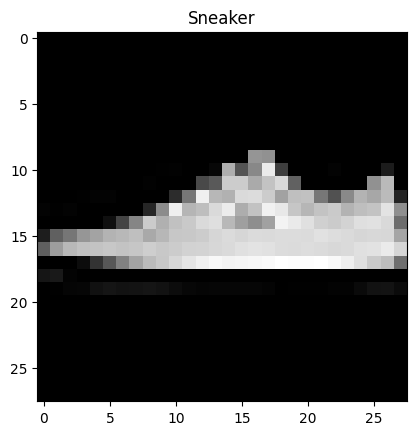

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_0,
                              data=test_samples)

# View first two pred probs
print(pred_probs[:2])

# Convert pred probs to labels
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)

# Print correct labels
print(test_labels)

tensor([[2.2941e-07, 2.5339e-07, 2.3183e-07, 4.3823e-06, 1.2532e-07, 1.2564e-02,
         5.9824e-07, 9.8685e-01, 8.9660e-05, 4.8925e-04],
        [1.3967e-05, 5.9918e-08, 2.6767e-06, 2.5860e-06, 1.2822e-07, 9.4587e-01,
         1.2643e-05, 1.0219e-05, 2.1619e-04, 5.3867e-02]])
tensor([7, 5, 9, 7, 0, 7, 8, 3, 3, 3, 6, 0, 6, 4, 3, 8, 7, 4, 3, 8, 0, 0, 4, 9,
        9, 1, 7, 4, 6, 3, 2, 5, 4, 0, 5, 8, 5, 9, 2, 3, 5, 1, 5, 3, 0, 8, 0, 2,
        1, 4, 3, 1, 6, 8, 4, 5, 9, 0, 7, 1, 2, 7, 0, 1, 3, 0, 7, 2, 8, 8, 9, 4,
        3, 6, 9, 3, 4, 1, 0, 5, 2, 9, 4, 0, 1, 8, 3, 7, 3, 5, 3, 1, 6, 7, 6, 0,
        9, 4, 7, 2])
[7, 5, 9, 7, 0, 7, 8, 3, 3, 3, 6, 6, 6, 4, 3, 8, 7, 4, 3, 8, 0, 0, 6, 9, 9, 1, 7, 4, 6, 6, 2, 5, 4, 0, 5, 8, 5, 9, 6, 3, 7, 1, 5, 3, 0, 8, 0, 2, 1, 4, 3, 1, 6, 8, 4, 5, 9, 0, 7, 1, 2, 7, 0, 1, 3, 0, 7, 2, 8, 8, 9, 4, 6, 6, 9, 3, 4, 1, 0, 5, 2, 9, 4, 0, 1, 8, 3, 7, 3, 5, 3, 1, 2, 7, 4, 0, 9, 4, 7, 2]


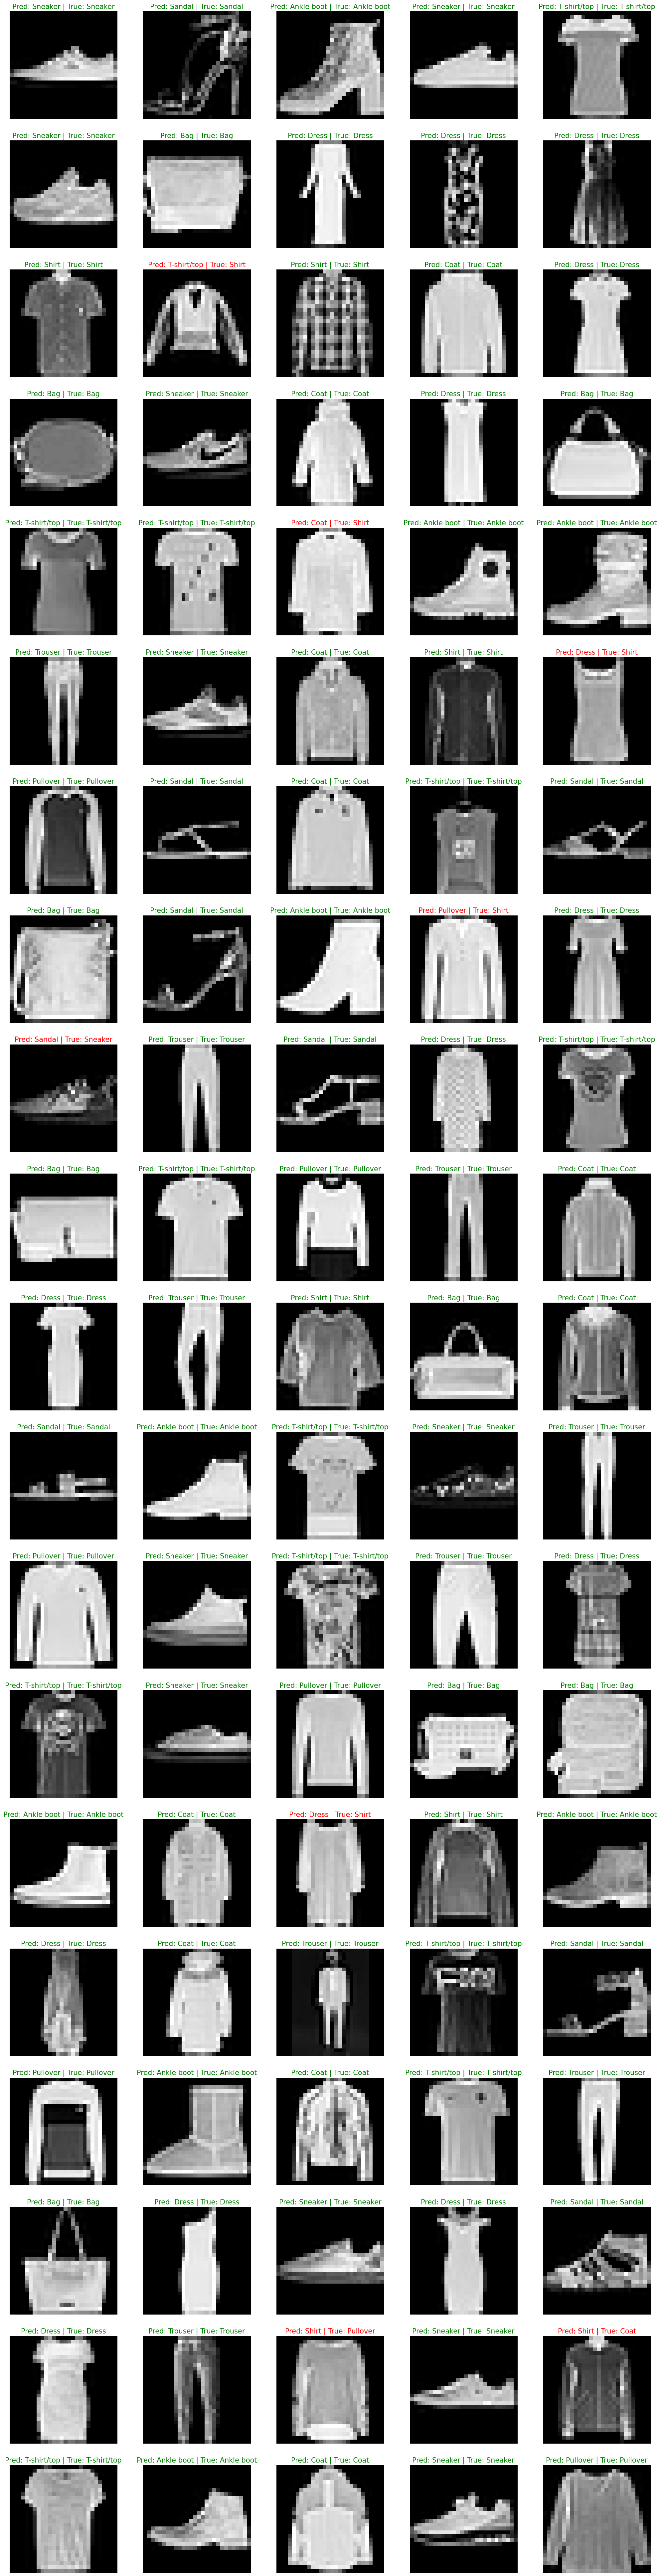

In [ ]:
# Plot predictions
plt.figure(figsize=(25,100))
nrows = 20
ncols = 5
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create title
  title_text = f"Pred: {pred_label} | True: {truth_label}"

  # Title color
  if pred_label == truth_label:
    plt.title(title_text, fontsize=15, c="g")
  else:
    plt.title(title_text, fontsize=15, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

In [ ]:
import mlxtend

In [ ]:
mlxtend.__version__

'0.22.0'

In [ ]:
from tqdm.auto import tqdm

# Make predictions using trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 0, 1, 6])

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
# See if required packages are installed, if not, install
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0
mlxtend version: 0.22.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
confmat_tensor

tensor([[599,   6,  27, 100,  15,   0, 240,   0,  13,   0],
        [  8, 865,   5, 103,  11,   0,   6,   0,   2,   0],
        [ 13,   7, 776,  15, 108,   0,  72,   0,   9,   0],
        [ 27,   6,  22, 885,  23,   0,  29,   1,   4,   3],
        [  5,   4, 119,  69, 710,   0,  88,   0,   5,   0],
        [  2,   0,   1,   9,   1, 745,  27,  84, 112,  19],
        [ 71,   7, 104,  77, 130,   0, 600,   0,  11,   0],
        [  1,   0,   0,   1,   0,  26,   1, 941,   7,  23],
        [ 13,   2,   3,  12,  13,   6,  16,   7, 926,   2],
        [  0,   0,   0,   8,   3,  26,   4, 146,  24, 789]])

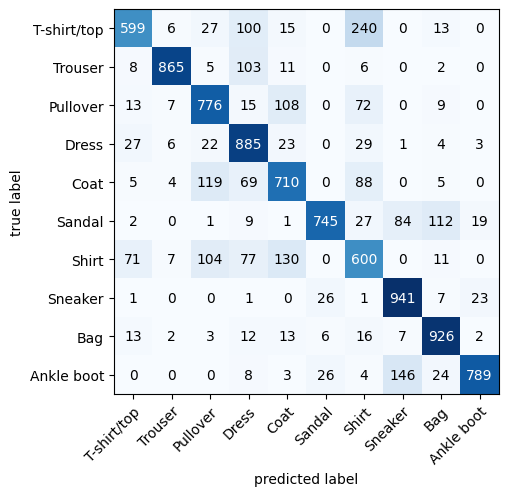

In [ ]:
# Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(5,5)
)

## 11. Save and load best performing model

In [ ]:
### SAVE ###

from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model save dict
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
### LOAD ###

# create a new instance
torch.manual_seed(14)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in saved state_dict
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded mdoel
torch.manual_seed(14)

loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)

loaded_model_2_results, model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.3338165581226349,
  'model_acc': 88.10902555910543},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.3338165581226349,
  'model_acc': 88.10902555910543})

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"])).item()

True